In [1]:
%matplotlib inline

In [2]:
import os
import json
import re

In [3]:
bdir = "./jobs/"
cnts = [ json.loads(open(bdir+fn, "r", encoding="utf8").read()) for fn in os.listdir(bdir)]

# 初步整理 pay_type

In [4]:
print (cnts[0]['pay_type'])

依學經歷、證照核薪


In [5]:
import collections

In [6]:
def count_pay_avg(pay_type):
    if re.search(u"[時|月|日]薪", pay_type):
        pay = pay_type.replace("時薪", '').replace("月薪", '').replace("日薪", '')
        (pay_up, pay_down) = pay.strip().split(" - ")
        pay_avg = (int(pay_up) + int(pay_down) )/2
        return pay_avg
    else:
        return pay_type

In [7]:
pay_types = collections.Counter([ count_pay_avg(x['pay_type']) for x in cnts])

In [8]:
import pandas as pd

In [9]:
pay_type_df = pd.DataFrame(pay_types.most_common(1000))

In [10]:
pay_type_df.columns = ['pay_mount', 'counter']

In [11]:
pay_type_df

,pay_mount,counter
0,依學經歷、證照核薪,5366
1,22000,491
2,140,416
3,30000,383
4,26000,345
5,27500,327
6,25000,304
7,35000,253
8,24000,247
9,28000,231


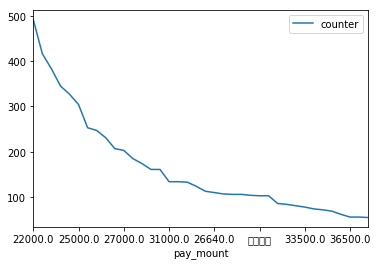

In [12]:
pay_type_df[(pay_type_df.counter < 500) & 
            (pay_type_df.counter > 50)].plot(x='pay_mount', y='counter')

# 準備 job_desc 的資料(x)

In [13]:
desc = [ x['job_desc'] for x in cnts]

In [14]:
print (desc[0])

徵:職業大貨車司機(自備貨車10.5噸、15噸、17噸)，工作內容:送貨與隨車助手，意者親洽或電洽。


In [15]:
import jieba

In [16]:
def token(txt):
    wrds = []
    for wrd in jieba.cut(txt):
        if re.match(u"[\u4e00-\u9fa5]+", wrd): #中文字
            wrds.append(wrd)
#         elif re.match("\d+", wrd): # 數字
#             wrds.append(wrd)
#         elif re.match("\w+", wrd): # 英文字
#             wrds.append(wrd)
        else:
            pass
    return wrds

In [17]:
print ( token(desc[0]) )

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ACERT1~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.719 seconds.
Prefix dict has been built succesfully.


['徵', '職業', '大貨車', '司機', '自備', '貨車', '噸', '噸', '噸', '工作', '內容', '送貨', '與', '隨車', '助手', '意者', '親洽', '或', '電洽']


## 使用 TFIDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tfidf = TfidfVectorizer(lowercase=False, 
                        sublinear_tf = True, 
                        max_df = 0.85, 
                        analyzer=lambda x: x, 
                        token_pattern=None) 

In [20]:
ans = tfidf.fit_transform([token(x) for x in desc])

In [21]:
feature_words = tfidf.get_feature_names()

In [22]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    return zip(feature_vals, score_vals)

In [23]:
feature_names=tfidf.get_feature_names()

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(ans.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,100)
 
# now print the results
print("\n===Keywords===")
for (w, s) in keywords:
    print("%s=%.2f"%(w, s))


===Keywords===
需輪班=1.00
鐵工=1.00
運輸=1.00
送貨=1.00
送貨=1.00
送貨=1.00
送貨=1.00
辦事員=1.00
設計=1.00
記帳=1.00
組裝產品=1.00
組裝=1.00
研磨=1.00
白鐵學徒=1.00
熟電腦=1.00
焊接=1.00
清潔維護=1.00
清潔員=1.00
水電維修=1.00
業務=1.00
木作=1.00
教學=1.00
收銀理貨=1.00
收銀作業=1.00
司機=1.00
半技師=1.00
包便當=1.00
剪鐵=1.00
出貨=1.00
倉儲理貨=1.00
作業員=1.00
作業員=1.00
財務會計=0.98
廚務=0.96
協助業務=0.95
廚具安裝=0.95
餐飲部=0.95
業務文書=0.95
推廣衛浴=0.94
照顧動物=0.94
燒焊=0.94
接待客人=0.93
廚房=0.93
铣床=0.93
農產品=0.93
收銀=0.92
內外場=0.92
商辦=0.92
廚務=0.92
蘭區=0.92
天車=0.91
生管=0.91
畜產品=0.91
店務=0.91
內衣=0.91
牙醫=0.91
百貨業=0.90
影印=0.90
拉直=0.90
廚務協助=0.90
廚具=0.90
商辦=0.90
銑床=0.90
銑床=0.90
螺絲=0.90
駐點=0.89
溫室=0.89
教學及=0.89
輪椅=0.89
水質=0.89
宿舍=0.89
氧環樹脂=0.89
氧環樹脂=0.89
電焊=0.89
電焊=0.89
餐飲內=0.88
餐飲內=0.88
醫院=0.88
玻璃=0.88
飛機=0.88
美編=0.88
車床=0.88
品管=0.87
倉庫=0.87
機械安裝=0.87
織帶=0.87
洗碗工=0.87
作會計=0.87
載貨=0.87
載貨=0.87
裝訂=0.86
裝訂=0.86
平面=0.86
繪圖=0.86
繪圖=0.86
餐具=0.86
餐具=0.86
車體=0.86
須細心=0.86
機器=0.86


## using Kmeans

In [24]:
from sklearn.cluster import KMeans

In [25]:
kmeans = KMeans(n_clusters=200, random_state=0)

In [26]:
kmeans = kmeans.fit(ans) # ans TFIDF 向量化的結果

In [27]:
kmeans.labels_.shape

(13321,)

In [28]:
print (ans.shape, len(desc))

(13321, 26021) 13321


In [29]:
ans[0]

<1x26021 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [30]:
desc[0]

'徵:職業大貨車司機(自備貨車10.5噸、15噸、17噸)，工作內容:送貨與隨車助手，意者親洽或電洽。'

In [31]:
label_dic = {}
for idx in range(len(desc)):
    kmean_label = kmeans.labels_[idx]
    if not kmean_label in label_dic:
        label_dic[ kmean_label ] = []
    label_dic[ kmean_label ].append(desc[idx])


In [32]:
print (label_dic.keys())

dict_keys([138, 116, 100, 178, 111, 117, 36, 14, 77, 144, 131, 35, 44, 88, 141, 193, 87, 90, 154, 112, 1, 109, 115, 171, 85, 28, 108, 142, 158, 192, 174, 119, 11, 128, 107, 163, 121, 101, 161, 91, 32, 86, 43, 118, 49, 122, 140, 164, 71, 23, 137, 98, 39, 70, 149, 181, 183, 53, 113, 65, 24, 124, 21, 165, 40, 62, 99, 169, 139, 37, 17, 114, 75, 27, 9, 155, 81, 60, 156, 42, 41, 187, 51, 63, 80, 34, 166, 20, 176, 69, 59, 48, 78, 96, 160, 130, 147, 4, 18, 94, 135, 150, 83, 151, 162, 180, 146, 153, 106, 143, 105, 64, 189, 73, 82, 15, 25, 172, 127, 7, 190, 196, 188, 186, 175, 102, 148, 199, 93, 57, 167, 185, 145, 125, 47, 55, 110, 79, 179, 54, 58, 3, 29, 177, 13, 198, 136, 129, 123, 68, 38, 16, 182, 26, 67, 191, 6, 134, 5, 92, 89, 194, 19, 170, 97, 12, 2, 84, 33, 173, 61, 195, 50, 52, 76, 157, 95, 159, 31, 132, 184, 22, 46, 197, 168, 126, 66, 10, 30, 56, 72, 104, 103, 120, 133, 45, 0, 74, 152, 8])


In [33]:
for lbl in label_dic.keys():
    print ("-"*10, lbl, "(%s)"%(len(label_dic[lbl])), "-"*10)
    print ("\n".join(label_dic[lbl][:3]))

---------- 138 (85) ----------
徵:職業大貨車司機(自備貨車10.5噸、15噸、17噸)，工作內容:送貨與隨車助手，意者親洽或電洽。
外勤.保養.銷售.送貨(數位複合機,列表機等辦公室自動化機器)
大貨車司機
---------- 116 (1023) ----------
徵:產品售後技術服務專員，工作內容:1.處理客戶客訴抱怨問題，廠內協調及追蹤品質改善活動。2. 英文聽說讀寫需精通程度。3.車輛、機械、電機、造船工程背景者尤佳,有相關工作經驗者亦可。
1.協助公司達成研發專案之目標。2.能操作實驗，並能對實驗數據進行分析與報告。3.協助研發產品推廣與量產整理與分析研究專案之文獻與資料。條件要求：1.化學、化工、環工、生物相關科系2.歡迎二度就業者加入我們的行列基本態度： 1.細心、負責2.積極主動、樂於溝通
1.工業鑽石相關產品之技術研發、設計、改良。2.研發相關實驗操作、分析及問題解決。3.協助新產品相關設計與開發。4.執行其他研發專案業務。條件要求：1.認真負責、積極主動2.重視團隊工作精神 3.邏輯力強、組織力佳4.理解、表達及溝通能力強
---------- 100 (1227) ----------
徵:粗工/清潔工，工作內容:工地整理，需搬重物，具工地經驗佳，請先電洽面試時間(陳小姐0958371188/0973356139)
預拌車(正職/固定代班)司機,日薪約1500元起意者電洽
無經驗可歡迎直接來電 預約面試時間
---------- 178 (3299) ----------
環管組長-文件處理 機動洗地打蠟
1.具餐飲服務熱忱，樂於學習、接受培訓2.宴會現場服務客人3.維護現場整潔、協助場地佈置4.協助上司管理與教導臨時工5.具四星級飯店餐飲工作經驗者佳
家事服務人員 飯店設施及客房清潔與保養
---------- 111 (110) ----------
1.具餐飲服務熱忱，樂於學習、接受培訓2.擔任顧客服務、內外場聯繫、點餐供餐、桌面及環境清潔等工作3.配合執行公司餐飲服務政策並維護服務品質4.具中式餐飲工作經驗者佳
餐廳外場服務 月休8天＊供食宿（需住宿）
外場接待、點菜服務
---------- 117 (138) ----------
零件加工
1.從事機械零件傳統車床加工2.6尺8尺10尺車床加工

---------- 56 (1) ----------
ISO 品質體系之執行、品管檢驗、儀器校正、各項品質議題專案樣品製作
---------- 72 (2) ----------
1.收銀、客戶服務2.商品介紹、銷售、櫃位整理
1.收銀、客戶服務2.商品介紹、銷售、櫃位整理
---------- 104 (1) ----------
徵:氬焊技工/半技工-焊接及切割、機械加工、各類金屬製品焊接。
---------- 103 (4) ----------
需有PCB製程、量測或光學檢驗、壓合製程經驗者佳。就業中心推介者，面試結果將如實回覆於介紹卡*請先電話預約面試時間*請先電話預約面試時間*請先電話預約面試時間
從事過相關治具製作工作、視力良好。就業中心推介者，面試結果將如實回覆於介紹卡*請先電話預約面試時間*請先電話預約面試時間*請先電話預約面試時間*請先電話預約面試時間
須具焊錫經驗，須會焊0.08mm漆包線。就業中心推介者，面試結果將如實回覆於介紹卡*請先電話預約面試時間*請先電話預約面試時間*請先電話預約面試時間
---------- 120 (1) ----------
半導體設備營業專員(新竹)，工作內容：1. 顧客定期拜訪(掌握客戶情報)2. 與日本總公司作客戶需求的聯繫及回覆溝通3. 定期參與顧客端與公司間的會議4. 客戶開發及訂單管理5. 內部單位溝通協調6. 產品進度開發與追蹤若有意應徵者，請先mail履歷至michael_lee@screen.com.tw合適者公司會主動通知面試，無誠勿擾。
---------- 133 (1) ----------
工務人員-現場管理及人員溝通、具汽車駕照。
---------- 45 (1) ----------
徵：送貨司機工作內容：送貨、包裝、退冰、載貨。【無求職意願者勿擾，請於上班時間電洽預約面試時間】
---------- 0 (1) ----------
徵：正職餐飲服務員  餐飲服務、外送、洗碗等工作，具機車駕照，月薪26000元以上，工作時間14:00-22:30，意者請先電洽約面試。(謝絕蓋章)
---------- 74 (1) ----------
1.協助電子工程師相關工作，樣品製作測試，產品文件圖面製作，BOM表建立。  2.協助產品開發設計與驗證測試。  3.協助產品設變問題

## install jieba

In [34]:
!pip install jieba

# install dill

In [35]:
!pip install dill

  Running setup.py bdist_wheel for dill: started
  Running setup.py bdist_wheel for dill: finished with status 'done'
  Stored in directory: C:\Users\ACER T110\AppData\Local\pip\Cache\wheels\e2\5d\17\f87cb7751896ac629b435a8696f83ee75b11029f5d6f6bda72
  Running setup.py bdist_wheel for pyreadline: started
  Running setup.py bdist_wheel for pyreadline: finished with status 'done'
  Stored in directory: C:\Users\ACER T110\AppData\Local\pip\Cache\wheels\70\66\59\590265c96902c7616243300c8f0d8ffe7800253ad55dfa9aa1
Successfully built dill pyreadline


In [36]:
import dill

In [38]:
dill.dump(tfidf, open("model_tfidf.dil", 'wb'))

In [39]:
dill.dump(kmeans, open("model_kmeans.dil", 'wb'))